# The Problem

The 2 most popular cities in South Africa are Cape Town and Durban [[1]](https://www.southafricavisa.com/cities-to-visit-in-south-africa/) [[2]](https://www.touropia.com/best-cities-to-visit-in-south-africa/). As an entrepreneur, Mark (fictional character for this project) has already identified the 2 cities previously mentioned as locations that he would want to start a business in. Mark wants to invest in whatever business is part of the top 5 most popular businesses in one of the cities and only plans on choosing one city to build his business.
The objective of this project is to identify popular businesses in each of the 2 South African cities and suggest 1 business that Mark could start a business in. 

# The Data
The foursquare API will be used to identify popular locations in each of the cities. The data with the names of the neighbourhoods in each city will be retrieved from a file stored at the following github link. The popularity of a venue on foursqaure is also influenced by how long it has existed on the foursqaure database and might not be representive of the venues current popularity compared to other venues.[[4]](https://silo.tips/download/exploring-venue-popularity-in-foursquare)

## Installing required packages

In [1]:
!pip install beautifulsoup4
!pip install geopy
!pip install folium==0.5.0
!pip install sklearn
!pip install pandas
!pip install squarify
print('Libraries installed')

Libraries installed


## Importing Packages

In [2]:
import pandas as pd
import numpy as np
import requests   #to make http(s) requests
from bs4 import BeautifulSoup #For web-scraping

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
import folium # map rendering library

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline
import squarify

#machine learning modules
from sklearn.cluster import KMeans #import k-means from clustering stage
from sklearn.metrics import silhouette_score
print('Libraries imported.')

Libraries imported.


## Downloading Data

#### Downloading github file with data
The neighbourhood data for each city is found in the following github link because all the data was retrieved from multiple websites. Neighbourhood name data was combined with postal code data from different websites as no single website with all postal codes was found.

In [3]:
capetown_link = 'https://raw.githubusercontent.com/sihlemkaza/Coursera_Capstone/main/CAPETOWN_CITY.csv'
durban_link = 'https://raw.githubusercontent.com/sihlemkaza/Coursera_Capstone/main/DURBAN_CITY.csv'

cpt_df = pd.read_csv(capetown_link)
dbn_df = pd.read_csv(durban_link)

print('Shape of Cape Town dataframe is {}'.format(cpt_df.shape))
print('Shape of Durban dataframe is {}'.format(dbn_df.shape))

Shape of Cape Town dataframe is (93, 3)
Shape of Durban dataframe is (81, 3)


In [4]:
cpt_df.head()

,Neighbourhood,Postal Code,City
0,Bakoven,8005,Cape Town
1,Bantry Bay,8005,Cape Town
2,Camps Bay,8005,Cape Town
3,Clifton,8005,Cape Town
4,Fresnaye,8005,Cape Town


In [5]:
dbn_df.head()

,Neighbourhood,Postal Code,City
0,Addington,4001,Durban
1,Austerville,4052,Durban
2,Avondale Road,4001,Durban
3,Bayhead,4052,Durban
4,Bellair,4094,Durban


### Excluding Postal Codes from the analysis
Even though each of the neighbourhoods have postal codes, some neighbourhoods (two or more) share the same postal code. Postal code is therefore not very representitive of each of the neighbourhoods as two neighbourhoods that share the same postal code can vary in the trends of businesses that people choose to go to [[3]](https://towardsdatascience.com/stop-using-zip-codes-for-geospatial-analysis-ceacb6e80c38).

#### Removing the postal code column in both dataframes

In [6]:
cpt_df.drop(['Postal Code'], axis = 1, inplace = True) #drop the postal code column
dbn_df.drop(['Postal Code'], axis = 1, inplace = True) #drop the postal code column

dataframes with postal code removed

In [7]:
cpt_df.head()

,Neighbourhood,City
0,Bakoven,Cape Town
1,Bantry Bay,Cape Town
2,Camps Bay,Cape Town
3,Clifton,Cape Town
4,Fresnaye,Cape Town


In [8]:
dbn_df.head()

,Neighbourhood,City
0,Addington,Durban
1,Austerville,Durban
2,Avondale Road,Durban
3,Bayhead,Durban
4,Bellair,Durban


## Getting Coordinates for each of the neighbourhoods

Function to get the coordinates of a given location

In [9]:
geolocator = Nominatim(user_agent="location_explorer")

def getLatLong(location):
    coordinates = geolocator.geocode(location)
    if(coordinates):
        location_lat = coordinates.latitude  #get latitude
        location_long = coordinates.longitude  #get longitude
    else:
        location_lat = None
        location_long = None
    return location_lat, location_long

create a new dataframe to add latitude and longitude

In [10]:
cpt_coordinates = pd.DataFrame(columns = ['Neighbourhood', 'Latitude', 'Longitude'])
dbn_coordinates = pd.DataFrame(columns = ['Neighbourhood', 'Latitude', 'Longitude'])

Getting coordinates for Cape Town Neighbourhoods

In [11]:
for index, row in cpt_df.iterrows():
        locationAddress = '{}, {}'.format(row['Neighbourhood'], row['City'])
        resultLatLong = getLatLong(locationAddress)
        cpt_coordinates = cpt_coordinates.append({'Neighbourhood': row['Neighbourhood'], 'Latitude': resultLatLong[0], 'Longitude': resultLatLong[1]}, ignore_index=True)
print('Shape of cpt_coordinates {}'.format(cpt_coordinates.shape))
cpt_coordinates.head()

Shape of cpt_coordinates (93, 3)


,Neighbourhood,Latitude,Longitude
0,Bakoven,-33.960000,18.382778
1,Bantry Bay,-33.928151,18.378970
2,Camps Bay,-33.954774,18.381852
3,Clifton,-33.935285,18.379070
4,Fresnaye,-33.925194,18.387743


Getting coordinates for Durban neighbourhoods

In [12]:
for index, row in dbn_df.iterrows():
        locationAddress = '{}, {}'.format(row['Neighbourhood'], row['City'])
        resultLatLong = getLatLong(locationAddress)
        dbn_coordinates = dbn_coordinates.append({'Neighbourhood': row['Neighbourhood'], 'Latitude': resultLatLong[0], 'Longitude': resultLatLong[1]}, ignore_index=True)
print('Shape of dbn_coordinates {}'.format(dbn_coordinates.shape))
dbn_coordinates.head()

Shape of dbn_coordinates (81, 3)


,Neighbourhood,Latitude,Longitude
0,Addington,-29.868127,31.043306
1,Austerville,-29.945278,30.980833
2,Avondale Road,-29.844753,31.009084
3,Bayhead,-29.891389,30.991389
4,Bellair,-29.892222,30.951667


## Merge Neighbourhood data with coordinate data

Left join since I want to keep all city data and only take matching neighbourhoods from coordinate dataframes

In [13]:
cpt_geo_df = pd.merge(left=cpt_df, right=cpt_coordinates, how='left', left_on='Neighbourhood', right_on='Neighbourhood')
print('Shape of cpt_geo_df {}'.format(cpt_geo_df.shape))
cpt_geo_df.head()

Shape of cpt_geo_df (93, 4)


,Neighbourhood,City,Latitude,Longitude
0,Bakoven,Cape Town,-33.960000,18.382778
1,Bantry Bay,Cape Town,-33.928151,18.378970
2,Camps Bay,Cape Town,-33.954774,18.381852
3,Clifton,Cape Town,-33.935285,18.379070
4,Fresnaye,Cape Town,-33.925194,18.387743


In [14]:
dbn_geo_df = pd.merge(left=dbn_df, right=dbn_coordinates, how='left', left_on='Neighbourhood', right_on='Neighbourhood')
print('Shape of dbn_geo_df {}'.format(dbn_geo_df.shape))
dbn_geo_df.head()

Shape of dbn_geo_df (81, 4)


,Neighbourhood,City,Latitude,Longitude
0,Addington,Durban,-29.868127,31.043306
1,Austerville,Durban,-29.945278,30.980833
2,Avondale Road,Durban,-29.844753,31.009084
3,Bayhead,Durban,-29.891389,30.991389
4,Bellair,Durban,-29.892222,30.951667


## Dealing with missing coordinates

#### Showing the neighbourhoods with missing data

In [15]:
cpt_geo_df[cpt_geo_df.isnull().any(axis=1)]

,Neighbourhood,City,Latitude,Longitude
24,Higgovale,Cape Town,NaN,NaN
25,Lower Vrede,Cape Town,NaN,NaN


In [16]:
dbn_geo_df[dbn_geo_df.isnull().any(axis=1)]

,Neighbourhood,City,Latitude,Longitude
73,Warwick Triangle,Durban,NaN,NaN


#### Removing neighbourhoods with missing location data

In [17]:
cpt_geo_df = cpt_geo_df.dropna().reset_index(drop=True) #drop rows with nan values and reset index 
print('Shape of cpt_geo_df after removing nan values = {}'.format(cpt_geo_df.shape))
dbn_geo_df = dbn_geo_df.dropna().reset_index(drop=True) #drop rows with nan values and reset index 
print('Shape of dbn_geo_df after removing nan values = {}'.format(dbn_geo_df.shape))

Shape of cpt_geo_df after removing nan values = (91, 4)
Shape of dbn_geo_df after removing nan values = (80, 4)


In [18]:
cpt_geo_df.head()

,Neighbourhood,City,Latitude,Longitude
0,Bakoven,Cape Town,-33.960000,18.382778
1,Bantry Bay,Cape Town,-33.928151,18.378970
2,Camps Bay,Cape Town,-33.954774,18.381852
3,Clifton,Cape Town,-33.935285,18.379070
4,Fresnaye,Cape Town,-33.925194,18.387743


In [19]:
dbn_geo_df.head()

,Neighbourhood,City,Latitude,Longitude
0,Addington,Durban,-29.868127,31.043306
1,Austerville,Durban,-29.945278,30.980833
2,Avondale Road,Durban,-29.844753,31.009084
3,Bayhead,Durban,-29.891389,30.991389
4,Bellair,Durban,-29.892222,30.951667


## Mapping & Visualising Neighbourhoods (before any clustering)

Funtion to create a folium map with location markers

In [20]:
def createMap(param_df, centet_latitude, center_longitude, markerColor, zoomSize):
    # create map using latitude and longitude to centre the map
    new_map = folium.Map(location=[centet_latitude, center_longitude], zoom_start=zoomSize)

    # add markers to map
    for lat, lng, city, neighbourhood in zip(param_df['Latitude'], param_df['Longitude'], param_df['City'], param_df['Neighbourhood']):
        label = '{}, {}'.format(neighbourhood, city)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color=markerColor,
            fill=True,
            fill_opacity=0.7,
            parse_html=False).add_to(new_map)  

    return new_map

## Cape Town Map

Get location of Cape Town to be used as center of map

In [21]:
cpt_latitude, cpt_longitude = getLatLong('Cape Town, South Africa')

In [22]:
cpt_map = createMap(cpt_geo_df, cpt_latitude, cpt_longitude, 'blue', 11)
cpt_map

## Durban Map

In [23]:
dbn_latitude, dbn_longitude = getLatLong('Durban, South Africa')

Get location of Durban to be used as center of map

In [24]:
dbn_map = createMap(dbn_geo_df, dbn_latitude, dbn_longitude, 'purple', 12)
dbn_map

## Creating Foursqaure credential variables

In [25]:
#Sensitive Data Hidden
#Assign values to CLIENT_ID and CLIENT_SECRET from foursqaure developer credentials

Four sqaure credentials variables 'CLIENT_ID' and 'CLIENT_SECRET' created


Foursqaure version & limit

In [26]:
VERSION = '20180604'
LIMIT = 100

## Functions for getting Foursquare data

Function that gets the venues/places in each neighbourhood

In [27]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [28]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):

    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        resultsResponse = requests.get(url).json()["response"]
        if('groups' in resultsResponse): #if the groups key exists in the json dictionary response, checking because on some occassions the groups key is missing
            
            results = resultsResponse['groups'][0]['items']

            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## Getting all Cape Town venues

In [29]:
#Get all Cape Town venues
cpt_venues = getNearbyVenues(names=cpt_geo_df['Neighbourhood'],
                                   latitudes=cpt_geo_df['Latitude'],
                                   longitudes=cpt_geo_df['Longitude']
                                  )
print('Shape of cpt_venues = {}'.format(cpt_venues.shape))
cpt_venues.head()


Shape of cpt_venues = (1074, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bakoven,-33.96,18.382778,Atlanticview Cape Town Boutique Hotel,-33.960127,18.385684,Hotel
1,Bakoven,-33.96,18.382778,Atlanticview Capetown,-33.959956,18.382522,Bed & Breakfast
2,Bakoven,-33.96,18.382778,3 On Camps Bay Guesthouse,-33.958574,18.378948,Bed & Breakfast
3,Bakoven,-33.96,18.382778,Upper Camps Bay,-33.963800,18.382742,Bed & Breakfast
4,Bakoven,-33.96,18.382778,Bayview Penthouses,-33.964225,18.382614,Bed & Breakfast


#### Seeing how many venues have been returned for each neighbourhood in Cape Town

In [30]:
cpt_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Athlone,1,1,1,1,1,1
Bakoven,5,5,5,5,5,5
Bantry Bay,14,14,14,14,14,14
Bellville,11,11,11,11,11,11
Bergvliet,2,2,2,2,2,2
...,...,...,...,...,...,...
Walmer Estate,5,5,5,5,5,5
West Beach,5,5,5,5,5,5
Woodstock,13,13,13,13,13,13


#### Number of unique categories in Cape Town

In [31]:
print('There are {} uniques categories.'.format(len(cpt_venues['Venue Category'].unique())))

There are 163 uniques categories.


## Getting all Durban venues

In [32]:
#Get all Durban venues
dbn_venues = getNearbyVenues(names=dbn_geo_df['Neighbourhood'],
                                   latitudes=dbn_geo_df['Latitude'],
                                   longitudes=dbn_geo_df['Longitude']
                                  )
print('Shape of dbn_venues = {}'.format(dbn_venues.shape))
dbn_venues.head()

Shape of dbn_venues = (486, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Addington,-29.868127,31.043306,Dolphin Stadium,-29.867237,31.044776,Stadium
1,Addington,-29.868127,31.043306,Happy Hippos Backpacker,-29.869003,31.042644,Hostel
2,Addington,-29.868127,31.043306,uShaka Beach,-29.866628,31.045344,Beach
3,Addington,-29.868127,31.043306,uShaka Marine World,-29.868841,31.046038,Aquarium
4,Addington,-29.868127,31.043306,uShaka Wet 'n Wild,-29.866598,31.045220,Water Park


#### Seeing how many venues have been returned for each neighbourhood in Durban

In [33]:
dbn_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Addington,32,32,32,32,32,32
Austerville,1,1,1,1,1,1
Avondale Road,11,11,11,11,11,11
Bayhead,1,1,1,1,1,1
Bellair,1,1,1,1,1,1
...,...,...,...,...,...,...
West Ridge,7,7,7,7,7,7
West Riding,7,7,7,7,7,7
Windermere,27,27,27,27,27,27


#### Number of unique categories in Durban

In [34]:
print('There are {} uniques categories.'.format(len(dbn_venues['Venue Category'].unique())))

There are 124 uniques categories.


## Analysing each Cape Town neighbourhood

To be able to use machine learning algorithms to analyse the types of trending venues, they have to be onehot encoded. For each row, if the venue fits a category a '1' will be used and where it doesn't fit the category a '0' is used.

#### Function to onehot encode

In [35]:
def getOneHotDF(param_df):
    # one hot encoding
    output_df = pd.get_dummies(param_df[['Venue Category']], prefix="", prefix_sep="")

    # add neighborhood column back to dataframe
    output_df['Neighbourhood'] = param_df['Neighbourhood'] 

    # move neighborhood column to the first column
    fixed_columns = [output_df.columns[-1]] + list(output_df.columns[:-1])
    output_df = output_df[fixed_columns]
    return output_df.copy(deep=True)

In [36]:
cpt_onehot = getOneHotDF(cpt_venues)
cpt_onehot.head()

,Neighbourhood,Accessories Store,African Restaurant,American Restaurant,Arcade,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,...,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Warehouse Store,Wine Bar,Wine Shop,Winery,Yoga Studio
0,Bakoven,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bakoven,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bakoven,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bakoven,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bakoven,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### group rows by neighbourhood and by taking the mean of the frequency of occurrence of each category

In [37]:
cpt_grouped = cpt_onehot.groupby('Neighbourhood').mean().reset_index()
cpt_grouped

,Neighbourhood,Accessories Store,African Restaurant,American Restaurant,Arcade,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,...,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Warehouse Store,Wine Bar,Wine Shop,Winery,Yoga Studio
0,Athlone,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Bakoven,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Bantry Bay,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bellville,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bergvliet,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,Walmer Estate,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82,West Beach,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83,Woodstock,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84,Wynberg,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Function to sort values in descending order

In [38]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

function to create a new dataframe and display the top n venues for each neighborhood.

In [39]:
def nTopVenuesDF(param_df, num_top_venues):
    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = ['Neighbourhood']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    output_df = pd.DataFrame(columns=columns)
    output_df['Neighbourhood'] = param_df['Neighbourhood']

    for ind in np.arange(param_df.shape[0]):
        output_df.iloc[ind, 1:] = return_most_common_venues(param_df.iloc[ind, :], num_top_venues)

    return output_df.copy(deep=True)

## Top 5 Venues in Cape Town in each neighbourhood

In [40]:
cpt_top_venues = nTopVenuesDF(cpt_grouped, 5)

Viewing first and last 10 rows

In [41]:
cpt_top_venues.head(10)

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Athlone,Jewelry Store,Yoga Studio,Factory,Fountain,Food Service
1,Bakoven,Bed & Breakfast,Hotel,Farm,Fountain,Food Service
2,Bantry Bay,Hotel,Hotel Pool,Dog Run,Scenic Lookout,Bed & Breakfast
3,Bellville,Bar,Bakery,Mexican Restaurant,Café,Other Nightlife
4,Bergvliet,Hockey Field,Breakfast Spot,Yoga Studio,Farm,Fountain
5,Bishopscourt,Hotel,Pub,Event Space,Food Service,Food & Drink Shop
6,Bloubergstrand,Hotel,Café,Seafood Restaurant,Farm,Food Service
7,Bo-Kaap,Café,Burger Joint,Restaurant,Steakhouse,Coffee Shop
8,Bothasig,Convenience Store,Yoga Studio,Factory,Food Service,Food & Drink Shop
9,Brooklyn,Furniture / Home Store,Bus Station,Fast Food Restaurant,Gym / Fitness Center,Factory


In [42]:
cpt_top_venues.tail(10)

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
76,Tokai,Tourist Information Center,Grocery Store,School,Pharmacy,Dessert Shop
77,University Estate,Restaurant,Supermarket,Café,Train Station,Gym
78,Valhalla Park,Breakfast Spot,Burger Joint,Restaurant,Asian Restaurant,Garden Center
79,Vredehoek,Café,Italian Restaurant,Grocery Store,Restaurant,Hotel
80,Vrygrond,Lake,Yoga Studio,Farm,Fountain,Food Service
81,Walmer Estate,Hotel,Convenience Store,Italian Restaurant,Fast Food Restaurant,Scenic Lookout
82,West Beach,Speakeasy,Hostel,Surf Spot,Health & Beauty Service,Sporting Goods Shop
83,Woodstock,Coffee Shop,Café,Hotel,Breakfast Spot,Mexican Restaurant
84,Wynberg,Grocery Store,Playground,Furniture / Home Store,Performing Arts Venue,Event Space
85,Zonnebloem,Gym,American Restaurant,Italian Restaurant,Coffee Shop,Theme Park


In [43]:
print('Shape of cpt_top_venues = {}'.format(cpt_top_venues.shape))

Shape of cpt_top_venues = (86, 6)


## Analysing each Durban neighbourhood

#### First get one hot encoded dataframe for durban

In [44]:
dbn_onehot = getOneHotDF(dbn_venues)
dbn_onehot.head()

,Neighbourhood,African Restaurant,Aquarium,Arts & Crafts Store,Athletics & Sports,Auto Workshop,BBQ Joint,Bakery,Bar,Baseball Field,...,Theater,Theme Park,Thrift / Vintage Store,Track,Track Stadium,Trail,Train Station,Video Store,Water Park,Women's Store
0,Addington,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Addington,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Addington,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Addington,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Addington,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


#### group rows by neighbourhood and by taking the mean of the frequency of occurrence of each category

In [45]:
dbn_grouped = dbn_onehot.groupby('Neighbourhood').mean().reset_index()
dbn_grouped

,Neighbourhood,African Restaurant,Aquarium,Arts & Crafts Store,Athletics & Sports,Auto Workshop,BBQ Joint,Bakery,Bar,Baseball Field,...,Theater,Theme Park,Thrift / Vintage Store,Track,Track Stadium,Trail,Train Station,Video Store,Water Park,Women's Store
0,Addington,0.03125,0.03125,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.03125,0.000000,0.0,0.0,0.0,0.000000,0.0,0.03125,0.0
1,Austerville,0.00000,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0
2,Avondale Road,0.00000,0.00000,0.000000,0.0,0.0,0.0,0.090909,0.0,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0
3,Bayhead,0.00000,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0
4,Bellair,0.00000,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.0,1.000000,0.0,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,West Ridge,0.00000,0.00000,0.142857,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.0,0.142857,0.0,0.00000,0.0
66,West Riding,0.00000,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0
67,Windermere,0.00000,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.00000,0.037037,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0
68,Windsor Park,0.00000,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0


## Top 5 Venues in Durban in each neighbourhood

In [46]:
dbn_top_venues = nTopVenuesDF(dbn_grouped, 5)

Viewing first and last 10 neighbourhoods in Durban

In [47]:
dbn_top_venues.head(10)

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Addington,Seafood Restaurant,Beach,Fast Food Restaurant,Café,Stadium
1,Austerville,Construction & Landscaping,Women's Store,Garden Center,Dessert Shop,Diner
2,Avondale Road,Boxing Gym,Bakery,Café,Garden,Shopping Mall
3,Bayhead,Gas Station,Garden Center,Department Store,Dessert Shop,Diner
4,Bellair,Train Station,Women's Store,Garden Center,Department Store,Dessert Shop
5,Berea,Coffee Shop,Café,Indian Restaurant,Multiplex,Cosmetics Shop
6,Berea Road,Pharmacy,Convenience Store,Breakfast Spot,Café,Sporting Goods Shop
7,Bishopsgate,Portuguese Restaurant,Train Station,Department Store,Playground,Fast Food Restaurant
8,Bluff,Construction & Landscaping,Burger Joint,Women's Store,Deli / Bodega,Dessert Shop
9,Botanic Gardens,Bakery,Garden,Women's Store,Gas Station,Dessert Shop


In [48]:
dbn_top_venues.tail(10)

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
60,Sydenham,Soccer Field,Women's Store,Garden,Department Store,Dessert Shop
61,Treasure Beach,Beach,Women's Store,Gas Station,Dessert Shop,Diner
62,Umgeni,Golf Course,Train Station,Brewery,Track,Women's Store
63,University Of Kwazulu Natal,Historic Site,Fast Food Restaurant,Theater,Women's Store,Garden
64,Wentworth,Seafood Restaurant,Supermarket,Clothing Store,Fast Food Restaurant,Fried Chicken Joint
65,West Ridge,Clothing Store,Pharmacy,Train Station,Arts & Crafts Store,Playground
66,West Riding,Italian Restaurant,Coffee Shop,Stationery Store,Supermarket,Fast Food Restaurant
67,Windermere,Steakhouse,Hotel,Portuguese Restaurant,Coffee Shop,Burger Joint
68,Windsor Park,Golf Course,Fast Food Restaurant,Harbor / Marina,Women's Store,Garden
69,Yellowwood Park,Grocery Store,Women's Store,Garden Center,Department Store,Dessert Shop


# Clustering neighbourhoods

Functions for clustering

In [49]:
#Function to run k means given a dataframe and number of clusters to be created
def runKMeans(param_df, num_of_clusters):
    output_grouped_clustering = param_df.drop('Neighbourhood', 1)

    # run k-means clustering
    kmeans = KMeans(n_clusters=num_of_clusters, random_state=0).fit(output_grouped_clustering)
    return kmeans

In [50]:
#function to create a dataframe with cluster values and longitude and latitude values along with top venues in each neighbourhood
def createDfWithClusters(df_top_venues, originalGeoDf, param_kmeans):
    top_venues_wClusters = df_top_venues.copy(deep=True)
    top_venues_wClusters.insert(0, 'Cluster Labels', param_kmeans.labels_)
    param_merged = originalGeoDf.copy(deep=True) # using a copy so that if a mistake is made, the original dataframe can be used to get the data
    param_merged = param_merged.join(top_venues_wClusters.set_index('Neighbourhood'), on='Neighbourhood')
    param_merged = param_merged.dropna().reset_index(drop=True) #drop rows with nan values and reset index
    return param_merged

## Finding optimal number of clusters for each city
For K Means clustering, the number of clusters must be specified when running the K Means algoirthm. To find the most optimal number of clusters to be used in each city, the 'Elbow' method will be used. This method requires running the k means algorithm with different values of k (number of clusters), calculating sum of square and plotting a function of sum of sqaure vs number of clusters. Where the graph has a sharp turn will be the k value to be used.

#### Functions for clustering data

In [51]:
def getKMeansDistortions(param_df, start_kValue, end_kValue):
    distortions = []
    k_list = range(start_kValue, end_kValue)
    for K in k_list:
        kMeans_model = runKMeans(param_df, K)
        distortions.append(kMeans_model.inertia_)
    return distortions, k_list

def plotElbowMethod(distortions,k_list, city):  
    plt.figure(figsize=(16,8))
    plt.plot(k_list, distortions, 'bx-')
    plt.xlabel('K')
    plt.xticks(k_list)
    plt.grid(True)
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k for {} clusters'.format(city))
    plt.show()
    
def getBestKValue(distortions):
    inertias = np.array(distortions)
    dif_inertias = inertias/inertias[0]
    dif_inertias = np.diff(dif_inertias)
    k_value = np.argwhere(dif_inertias < np.quantile(dif_inertias,0.9))[-1][0]
    return k_value

## Finding optimal number of clusters from Cape Town using the elbow method

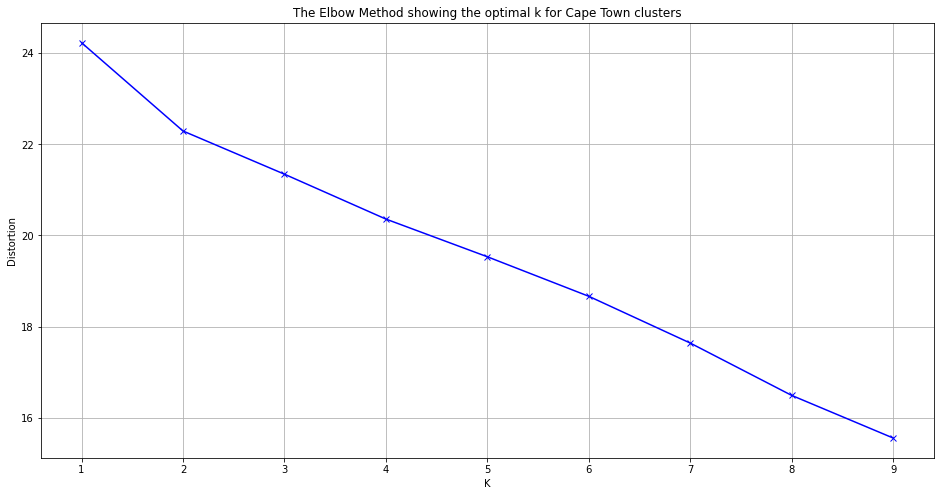

Best K Value for Cape Town using elbow method is 7


In [52]:
cpt_distortions, cpt_k_list = getKMeansDistortions(cpt_grouped, 1, 10)
plotElbowMethod(cpt_distortions, cpt_k_list, 'Cape Town')
cpt_k_value = getBestKValue(cpt_distortions)
print('Best K Value for {} using elbow method is {}'.format('Cape Town',cpt_k_value))

### Cape Town Clustering

In [53]:
cpt_num_of_clusters = cpt_k_value
cpt_kmeans = runKMeans(cpt_grouped, cpt_num_of_clusters)

In [54]:
cpt_clustered_venues = createDfWithClusters(cpt_top_venues, cpt_geo_df, cpt_kmeans)
cpt_clustered_venues

,Neighbourhood,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bakoven,Cape Town,-33.960000,18.382778,0.0,Bed & Breakfast,Hotel,Farm,Fountain,Food Service
1,Bantry Bay,Cape Town,-33.928151,18.378970,0.0,Hotel,Hotel Pool,Dog Run,Scenic Lookout,Bed & Breakfast
2,Camps Bay,Cape Town,-33.954774,18.381852,0.0,Hotel,Seafood Restaurant,Italian Restaurant,Restaurant,Ice Cream Shop
3,Clifton,Cape Town,-33.935285,18.379070,2.0,Beach,Hotel,Farm,Fountain,Food Service
4,Fresnaye,Cape Town,-33.925194,18.387743,0.0,Hotel,Bed & Breakfast,Farm,Fountain,Food Service
...,...,...,...,...,...,...,...,...,...,...
81,Bloubergstrand,Cape Town,-33.797336,18.461023,0.0,Hotel,Café,Seafood Restaurant,Farm,Food Service
82,Darling,Cape Town,-33.924321,18.422784,0.0,Café,Coffee Shop,Hotel,Bar,Restaurant
83,Montague Gardens,Cape Town,-33.859750,18.522916,0.0,Dance Studio,Auto Garage,Paper / Office Supplies Store,Fast Food Restaurant,Kitchen Supply Store
84,Table View,Cape Town,-33.823611,18.490278,0.0,Department Store,Shopping Mall,Café,Fast Food Restaurant,Accessories Store


In [55]:
print('There are {} clusters for Cape Town.'.format(len(cpt_clustered_venues['Cluster Labels'].unique())))

There are 7 clusters for Cape Town.


## Finding optimal number of clusters for Durban using the elbow method

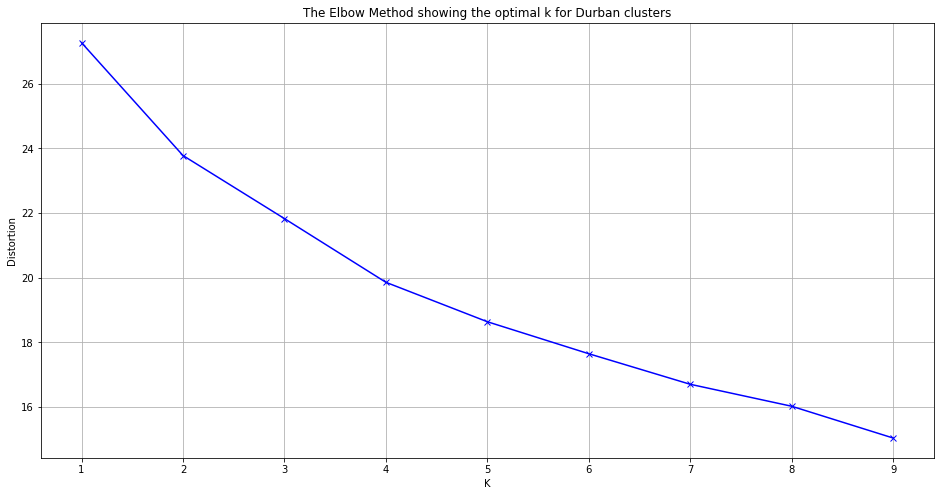

Best K Value for Durban using elbow method is 7


In [56]:
dbn_distortions, dbn_k_list = getKMeansDistortions(dbn_grouped, 1, 10)
plotElbowMethod(dbn_distortions, dbn_k_list, 'Durban')
dbn_k_value = getBestKValue(dbn_distortions)
print('Best K Value for {} using elbow method is {}'.format('Durban',dbn_k_value))

### Durban Clustering

In [57]:
dbn_num_of_clusters = dbn_k_value
dbn_kmeans = runKMeans(dbn_grouped,dbn_num_of_clusters)

In [58]:
dbn_clustered_venues = createDfWithClusters(dbn_top_venues, dbn_geo_df, dbn_kmeans)
dbn_clustered_venues

,Neighbourhood,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Addington,Durban,-29.868127,31.043306,1.0,Seafood Restaurant,Beach,Fast Food Restaurant,Café,Stadium
1,Austerville,Durban,-29.945278,30.980833,2.0,Construction & Landscaping,Women's Store,Garden Center,Dessert Shop,Diner
2,Avondale Road,Durban,-29.844753,31.009084,1.0,Boxing Gym,Bakery,Café,Garden,Shopping Mall
3,Bayhead,Durban,-29.891389,30.991389,4.0,Gas Station,Garden Center,Department Store,Dessert Shop,Diner
4,Bellair,Durban,-29.892222,30.951667,0.0,Train Station,Women's Store,Garden Center,Department Store,Dessert Shop
...,...,...,...,...,...,...,...,...,...,...
65,West Ridge,Durban,-29.861825,31.009909,1.0,Clothing Store,Pharmacy,Train Station,Arts & Crafts Store,Playground
66,West Riding,Durban,-29.830616,30.966420,1.0,Italian Restaurant,Coffee Shop,Stationery Store,Supermarket,Fast Food Restaurant
67,Windermere,Durban,-29.832731,31.017483,1.0,Steakhouse,Hotel,Portuguese Restaurant,Coffee Shop,Burger Joint
68,Windsor Park,Durban,-29.813864,31.028800,1.0,Golf Course,Fast Food Restaurant,Harbor / Marina,Women's Store,Garden


In [59]:
print('There are {} clusters for Durban.'.format(len(dbn_clustered_venues['Cluster Labels'].unique())))

There are 7 clusters for Durban.


# Mapping City Clusters

Each cluster will have a different color. Creating colors randomly might produce colors that look similar for different clusters. To avoid this, a csv file with unique colors that differ enough visually to be used for clustering was created and will be used to pick colors for the clusters.

In [60]:
rgb_colors_link = 'https://raw.githubusercontent.com/sihlemkaza/Coursera_Capstone/main/HEX_RGB_COLORS.csv'
rgb_df = pd.read_csv(rgb_colors_link)
print('Shape of rgb_df = {}'.format(rgb_df.shape))
colors_list = rgb_df['HEX_RGB'].to_list()
rgb_df.head()

Shape of rgb_df = (21, 2)


,Name,HEX_RGB
0,Absolute Zero,#0048BA
1,Acid green,#B0BF1A
2,Amber,#FFBF00
3,Byzantine,#BD33A4
4,Amaranth,#E52B50


Function to create map with clusters

In [61]:
def createClusterMap(param_df,center_latitude, center_longitude, zoom, num_of_clusters):
    # create map
    map_clusters = folium.Map(location=[center_latitude, center_longitude], zoom_start=zoom)

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(param_df['Latitude'], param_df['Longitude'], param_df['Neighbourhood'], param_df['Cluster Labels']):
        cluster = int(cluster)
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=colors_list[cluster],
            fill=True,
            fill_color=colors_list[cluster],
            fill_opacity=0.7).add_to(map_clusters)
        
    return map_clusters

## Map of Cape Town clusters

In [62]:
zoom = 11
cpt_map_cluster = createClusterMap(cpt_clustered_venues, cpt_latitude, cpt_longitude, zoom, cpt_num_of_clusters)
cpt_map_cluster

## List of Cape Town Clusters

### Cluster label 0, Cape Town

In [63]:
cpt_clustered_venues.loc[cpt_clustered_venues['Cluster Labels'] == 0, cpt_clustered_venues.columns[[0] + list(range(4, cpt_clustered_venues.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bakoven,0.0,Bed & Breakfast,Hotel,Farm,Fountain,Food Service
1,Bantry Bay,0.0,Hotel,Hotel Pool,Dog Run,Scenic Lookout,Bed & Breakfast
2,Camps Bay,0.0,Hotel,Seafood Restaurant,Italian Restaurant,Restaurant,Ice Cream Shop
4,Fresnaye,0.0,Hotel,Bed & Breakfast,Farm,Fountain,Food Service
5,Green Point,0.0,Park,Hostel,Athletics & Sports,Golf Course,Liquor Store
...,...,...,...,...,...,...,...
81,Bloubergstrand,0.0,Hotel,Café,Seafood Restaurant,Farm,Food Service
82,Darling,0.0,Café,Coffee Shop,Hotel,Bar,Restaurant
83,Montague Gardens,0.0,Dance Studio,Auto Garage,Paper / Office Supplies Store,Fast Food Restaurant,Kitchen Supply Store
84,Table View,0.0,Department Store,Shopping Mall,Café,Fast Food Restaurant,Accessories Store


### Cluster label, 1 Cape Town

In [64]:
cpt_clustered_venues.loc[cpt_clustered_venues['Cluster Labels'] == 1, cpt_clustered_venues.columns[[0] + list(range(4, cpt_clustered_venues.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
12,Nyanga,1.0,Train Station,Yoga Studio,Factory,Fountain,Food Service
43,Panorama,1.0,Train Station,Yoga Studio,Factory,Fountain,Food Service


### Cluster label 2, Cape Town

In [65]:
cpt_clustered_venues.loc[cpt_clustered_venues['Cluster Labels'] == 2, cpt_clustered_venues.columns[[0] + list(range(4, cpt_clustered_venues.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,Clifton,2.0,Beach,Hotel,Farm,Fountain,Food Service


### Cluster label 3, Cape Town

In [66]:
cpt_clustered_venues.loc[cpt_clustered_venues['Cluster Labels'] == 3, cpt_clustered_venues.columns[[0] + list(range(4, cpt_clustered_venues.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
35,Edgemead,3.0,Electronics Store,Yoga Studio,Farm,Fountain,Food Service


### Cluster label 4, Cape Town

In [67]:
cpt_clustered_venues.loc[cpt_clustered_venues['Cluster Labels'] == 4, cpt_clustered_venues.columns[[0] + list(range(4, cpt_clustered_venues.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
9,Athlone,4.0,Jewelry Store,Yoga Studio,Factory,Fountain,Food Service


### Cluster label 5, Cape Town

In [68]:
cpt_clustered_venues.loc[cpt_clustered_venues['Cluster Labels'] == 5, cpt_clustered_venues.columns[[0] + list(range(4, cpt_clustered_venues.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
16,Vrygrond,5.0,Lake,Yoga Studio,Farm,Fountain,Food Service


### Cluster label 6, Cape Town

In [69]:
cpt_clustered_venues.loc[cpt_clustered_venues['Cluster Labels'] == 6, cpt_clustered_venues.columns[[0] + list(range(4, cpt_clustered_venues.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
10,Crawford,6.0,Convenience Store,Hotel,Pizza Place,Park,Fast Food Restaurant
33,Bothasig,6.0,Convenience Store,Yoga Studio,Factory,Food Service,Food & Drink Shop
42,Monte Vista,6.0,Convenience Store,Pharmacy,Pizza Place,Tennis Court,Coffee Shop
51,Marina da Gama,6.0,Pharmacy,Pizza Place,Fast Food Restaurant,Gas Station,Convenience Store
64,Kenwyn,6.0,Park,Construction & Landscaping,Yoga Studio,Factory,Food Service
67,Lansdowne,6.0,Nightclub,Convenience Store,Bakery,Factory,Food Service
68,Meadowridge,6.0,Soccer Field,Park,Convenience Store,Gas Station,Grocery Store
74,Rondebosch,6.0,Playground,Convenience Store,Construction & Landscaping,Yoga Studio,Factory
78,Steenberg,6.0,Gas Station,Yoga Studio,French Restaurant,Food Service,Food & Drink Shop


## Map of Durban clusters

In [70]:
dbn_zoom = 12
dbn_map_cluster = createClusterMap(dbn_clustered_venues, dbn_latitude, dbn_longitude, dbn_zoom, dbn_num_of_clusters)
dbn_map_cluster

## List of Durban clusters

### Cluster label 0, Durban

In [71]:
dbn_clustered_venues.loc[dbn_clustered_venues['Cluster Labels'] == 0, dbn_clustered_venues.columns[[0] + list(range(4, dbn_clustered_venues.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
4,Bellair,0.0,Train Station,Women's Store,Garden Center,Department Store,Dessert Shop
15,Dalbridge,0.0,Train Station,Women's Store,Garden Center,Department Store,Dessert Shop


### Cluster label 1, Durban

In [72]:
dbn_clustered_venues.loc[dbn_clustered_venues['Cluster Labels'] == 1, dbn_clustered_venues.columns[[0] + list(range(4, dbn_clustered_venues.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Addington,1.0,Seafood Restaurant,Beach,Fast Food Restaurant,Café,Stadium
2,Avondale Road,1.0,Boxing Gym,Bakery,Café,Garden,Shopping Mall
5,Berea,1.0,Coffee Shop,Café,Indian Restaurant,Multiplex,Cosmetics Shop
6,Berea Road,1.0,Pharmacy,Convenience Store,Breakfast Spot,Café,Sporting Goods Shop
7,Bishopsgate,1.0,Portuguese Restaurant,Train Station,Department Store,Playground,Fast Food Restaurant
9,Botanic Gardens,1.0,Bakery,Garden,Women's Store,Gas Station,Dessert Shop
10,Brighton Beach,1.0,Boat or Ferry,Campground,Golf Course,Surf Spot,Furniture / Home Store
11,Carrington Heights,1.0,Lounge,Supermarket,BBQ Joint,Park,Women's Store
13,Clairwood,1.0,Indian Restaurant,Home Service,Burger Joint,Women's Store,Garden
16,Durban North,1.0,Spa,Jazz Club,Hotel,Construction & Landscaping,Flea Market


### Cluster label 2, Durban

In [73]:
dbn_clustered_venues.loc[dbn_clustered_venues['Cluster Labels'] == 2, dbn_clustered_venues.columns[[0] + list(range(4, dbn_clustered_venues.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Austerville,2.0,Construction & Landscaping,Women's Store,Garden Center,Dessert Shop,Diner
8,Bluff,2.0,Construction & Landscaping,Burger Joint,Women's Store,Deli / Bodega,Dessert Shop
12,Cato Manor,2.0,Construction & Landscaping,Lawyer,Women's Store,Garden Center,Dessert Shop
25,Hillary,2.0,Construction & Landscaping,Women's Store,Garden Center,Dessert Shop,Diner
27,Jacobs,2.0,Arts & Crafts Store,Construction & Landscaping,Women's Store,Garden Center,Dessert Shop
38,Mount Vernon,2.0,Construction & Landscaping,Café,Women's Store,Deli / Bodega,Dessert Shop
45,Palmiet,2.0,Construction & Landscaping,Women's Store,Garden Center,Dessert Shop,Diner
48,Queensburgh,2.0,Construction & Landscaping,Bed & Breakfast,Women's Store,Garden Center,Dessert Shop


### Cluster label 3, Durban

In [74]:
dbn_clustered_venues.loc[dbn_clustered_venues['Cluster Labels'] == 3, dbn_clustered_venues.columns[[0] + list(range(4, dbn_clustered_venues.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
14,Congella,3.0,Indian Restaurant,Arts & Crafts Store,Furniture / Home Store,Women's Store,Garden Center
24,Happy Valley,3.0,Indian Restaurant,Women's Store,Garden Center,Department Store,Dessert Shop
50,Reservoir Hills,3.0,Indian Restaurant,Women's Store,Garden Center,Department Store,Dessert Shop


### Cluster label 4, Durban

In [75]:
dbn_clustered_venues.loc[dbn_clustered_venues['Cluster Labels'] == 4, dbn_clustered_venues.columns[[0] + list(range(4, dbn_clustered_venues.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,Bayhead,4.0,Gas Station,Garden Center,Department Store,Dessert Shop,Diner
47,Durban Point,4.0,Gas Station,Nudist Beach,Women's Store,Garden,Department Store


### Cluster label 5, Durban

In [76]:
dbn_clustered_venues.loc[dbn_clustered_venues['Cluster Labels'] == 5, dbn_clustered_venues.columns[[0] + list(range(4, dbn_clustered_venues.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
29,Kings Rest,5.0,Auto Workshop,Women's Store,Gas Station,Dessert Shop,Diner


### Cluster label 6, Durban

In [77]:
dbn_clustered_venues.loc[dbn_clustered_venues['Cluster Labels'] == 6, dbn_clustered_venues.columns[[0] + list(range(4, dbn_clustered_venues.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
35,Montclair,6.0,Burger Joint,Women's Store,Garden Center,Dessert Shop,Diner


## Visualising venue category counts per cluster

In [79]:
def createSumOfVenueByCluster(onehot_df, clustered_venues_df):
    sum_of_category_by_neighbourhood = onehot_df.groupby('Neighbourhood').sum().reset_index() #get the sum of each category in each neighbourhood
    neighbourhood_clusters = clustered_venues_df[['Neighbourhood', 'Cluster Labels']] #create dataframe with neighbourhood and cluster labels columns
    #create dataframe with cluster label for each neighbourhood and category sums
    category_sum_per_cluster = pd.merge(left=neighbourhood_clusters, right=sum_of_category_by_neighbourhood, how='left', left_on='Neighbourhood', right_on='Neighbourhood')
    category_sum_per_cluster.drop(['Neighbourhood'], axis = 1, inplace = True) #drop neighbourhood column
    output_df = category_sum_per_cluster.groupby('Cluster Labels').sum().reset_index() #group by cluster
    return output_df

def createTranspose(df_venues_per_cluster):
    output_df = df_venues_per_cluster.drop(['Cluster Labels'], axis = 1, inplace = False) #drop cluster labels as index values == cluster name already
    category_list = list(output_df.columns)
    output_df = output_df.T #create transpose, making index values the new columns
    output_df['Category'] = category_list #add a category column
    output_df.reset_index(inplace = True, drop = True)
    return output_df

In [90]:
def createTreeMap(param_df, cluster_column, width, height, city):
    output_df = param_df[['Category',cluster_column]] #make dataframe using the Category and cluster column
    output_df = output_df[output_df[cluster_column]!=0] #remove all rows where cluster value number is zero for a category
    output_df = output_df.sort_values(by=1, ascending=True) 
    ax = plt.figure(figsize=(width,height))
    ax = ax.add_subplot(111, aspect="equal")
    ax.set_title('Number of venues per category for Cluster {} in {}'.format(cluster_column, city), fontsize=14)
    output_df['Category_w_Total'] = output_df['Category'] + "\n" +  output_df[1].map(str) #add column with category and total
    squarify.plot(sizes=output_df[cluster_column], label=output_df['Category_w_Total'], ax=ax, alpha=.8, bar_kwargs=dict(linewidth=1, edgecolor="#000000"))
    plt.axis('off')
    plt.show()

def createBarGraph(param_df, cluster_column, width, height, city):
    output_df = param_df[['Category',cluster_column]] #make dataframe using the Category and cluster column
    output_df = output_df[output_df[cluster_column]!=0] #remove all rows where cluster value number is zero for a category
    output_df = output_df.set_index('Category')
    output_df.plot(kind='bar', figsize=(width, height), rot=90) 
    plt.xlabel('Category')
    plt.ylabel('Number of venues')
    plt.title('Number of venues per Category for Cluster {} in {}'.format(cluster_column, city))
    #plt.grid(True)
    plt.show()

## Number of different category venues per cluster in Cape Town

Get number of venues per category in each cluster

In [86]:
cpt_sum_per_cluster = createSumOfVenueByCluster(cpt_onehot, cpt_clustered_venues)
cpt_sum_per_cluster

,Cluster Labels,Accessories Store,African Restaurant,American Restaurant,Arcade,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,...,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Warehouse Store,Wine Bar,Wine Shop,Winery,Yoga Studio
0,0.0,1,9,2,1,4,1,10,4,1,...,2,7,1,7,5,2,3,1,3,2
1,1.0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
2,2.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,5.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,6.0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


create transpose of summed categories for use in graphs/visualisations

In [87]:
cpt_sum_transpose = createTranspose(cpt_sum_per_cluster)
cpt_sum_transpose

,0,1,2,3,4,5,6,Category
0,1,0,0,0,0,0,0,Accessories Store
1,9,0,0,0,0,0,0,African Restaurant
2,2,0,0,0,0,0,0,American Restaurant
3,1,0,0,0,0,0,0,Arcade
4,4,0,0,0,0,0,0,Art Museum
...,...,...,...,...,...,...,...,...
158,2,0,0,0,0,0,0,Warehouse Store
159,3,0,0,0,0,0,0,Wine Bar
160,1,0,0,0,0,0,0,Wine Shop
161,3,0,0,0,0,0,0,Winery


## Visualising each Cape Town cluster

Each cluster has a number of venues for each category. To make the visualisations clearer and not cluttered with empty bars (where number of venues is zero for a category) only categories with number of venues greater than 0 are shown in the graphs.

### Cape Town Cluster label 0

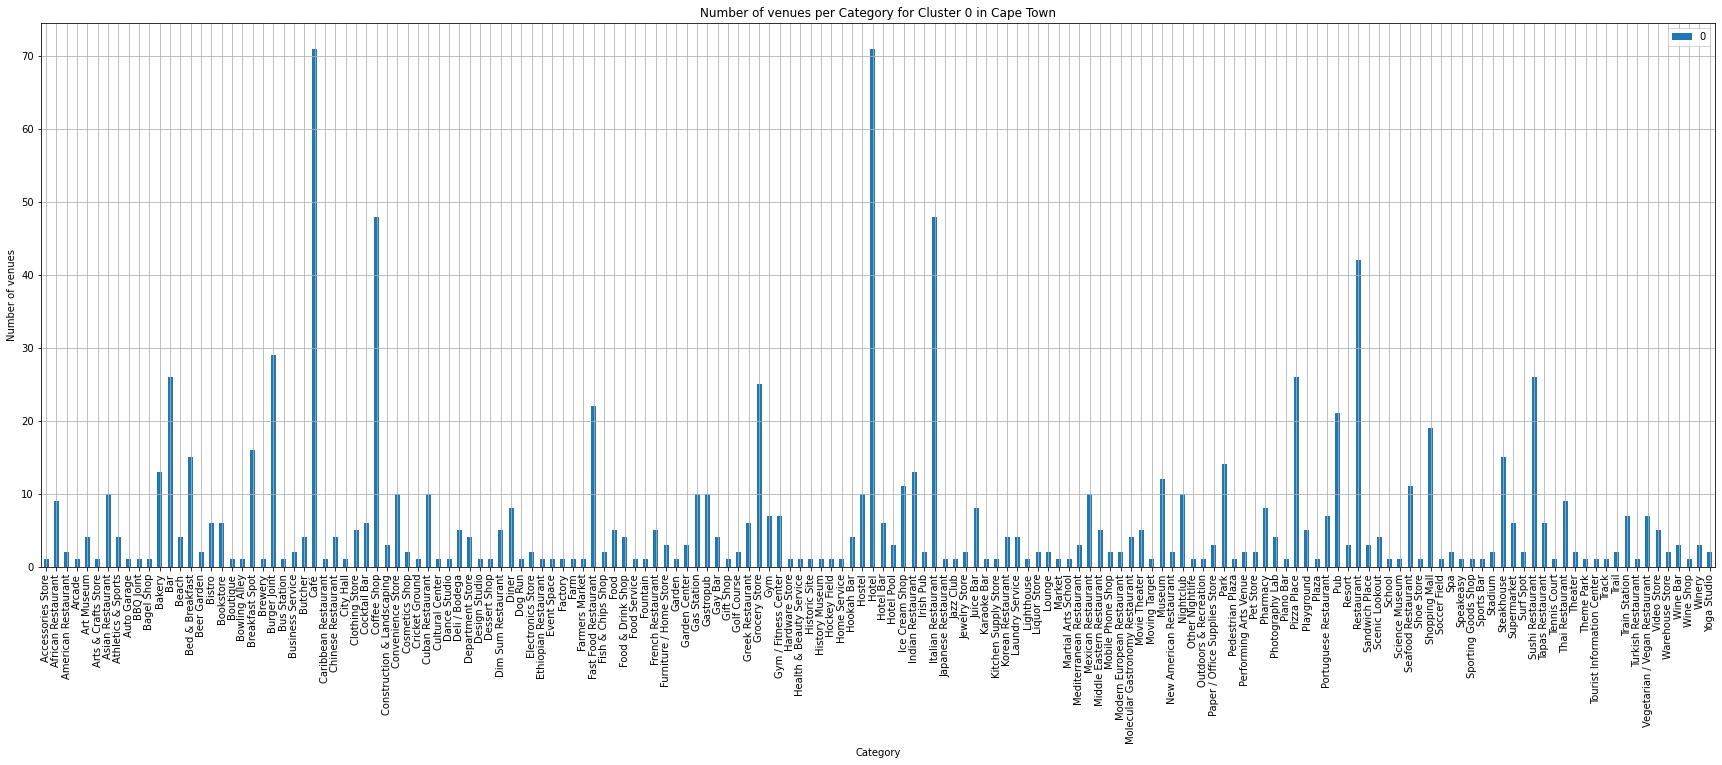

In [88]:
createBarGraph(cpt_sum_transpose, 0, 30,10, 'Cape Town')

### Cape Town Cluster label 1

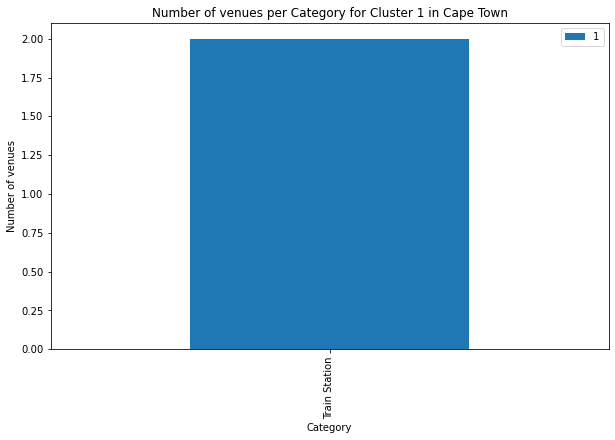

In [91]:
createBarGraph(cpt_sum_transpose, 1, 10,6, 'Cape Town')

### Cape Town Cluster label 2

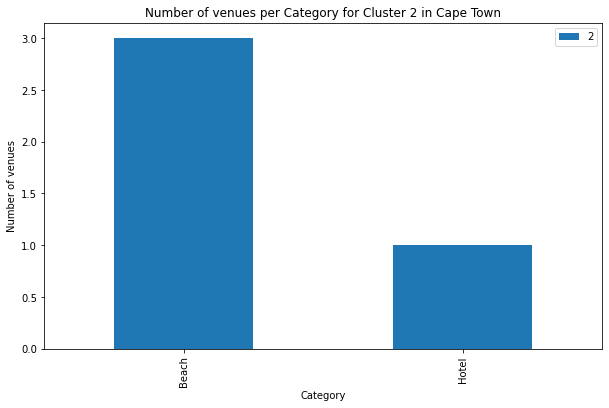

In [92]:
createBarGraph(cpt_sum_transpose, 2, 10,6, 'Cape Town')

### Cape Town Cluster label 3

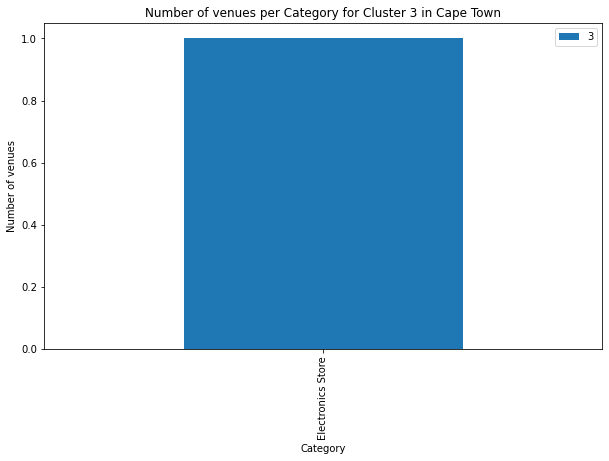

In [93]:
createBarGraph(cpt_sum_transpose, 3, 10,6, 'Cape Town')

### Cape Town Cluster label 4

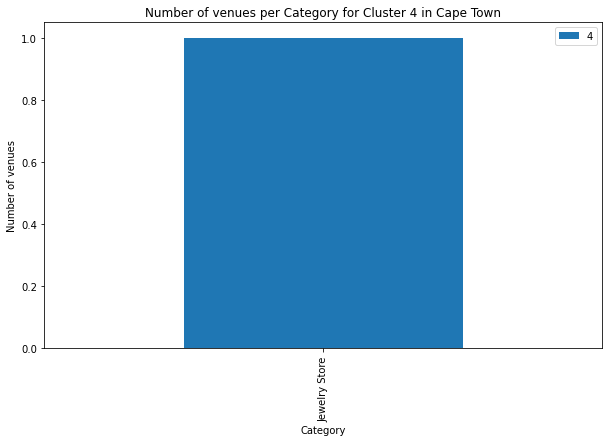

In [94]:
createBarGraph(cpt_sum_transpose, 4, 10,6, 'Cape Town')

### Cape Town Cluster label 5

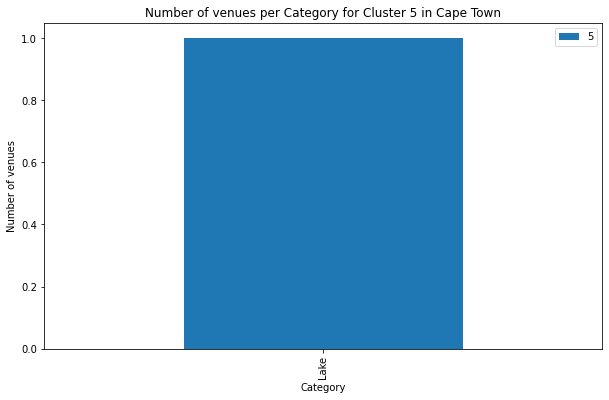

In [97]:
createBarGraph(cpt_sum_transpose, 5, 10,6, 'Cape Town')

### Cape Town Cluster label 6

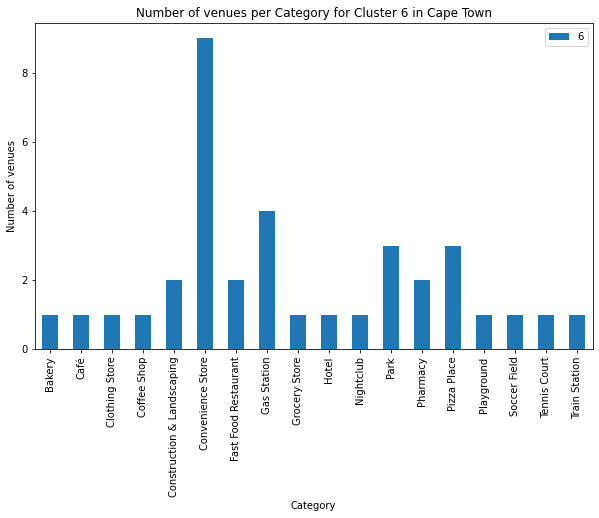

In [96]:
createBarGraph(cpt_sum_transpose, 6, 10,6, 'Cape Town')

## Number of different category venues per cluster in Durban

Get number of venues per category in each cluster

In [98]:
dbn_sum_per_cluster = createSumOfVenueByCluster(dbn_onehot, dbn_clustered_venues)
dbn_sum_per_cluster

,Cluster Labels,African Restaurant,Aquarium,Arts & Crafts Store,Athletics & Sports,Auto Workshop,BBQ Joint,Bakery,Bar,Baseball Field,...,Theater,Theme Park,Thrift / Vintage Store,Track,Track Stadium,Trail,Train Station,Video Store,Water Park,Women's Store
0,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
1,1.0,1,1,4,1,2,1,4,1,2,...,2,1,1,1,1,1,5,1,1,1
2,2.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,5.0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,6.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


create transpose of summed categories for use in graphs/visualisations

In [99]:
dbn_sum_transpose = createTranspose(dbn_sum_per_cluster)
dbn_sum_transpose

,0,1,2,3,4,5,6,Category
0,0,1,0,0,0,0,0,African Restaurant
1,0,1,0,0,0,0,0,Aquarium
2,0,4,1,1,0,0,0,Arts & Crafts Store
3,0,1,0,0,0,0,0,Athletics & Sports
4,0,2,0,0,0,1,0,Auto Workshop
...,...,...,...,...,...,...,...,...
119,0,1,0,0,0,0,0,Trail
120,2,5,0,0,0,0,0,Train Station
121,0,1,0,0,0,0,0,Video Store
122,0,1,0,0,0,0,0,Water Park


## Visualising each Durban cluster

### Durban Cluster label 0

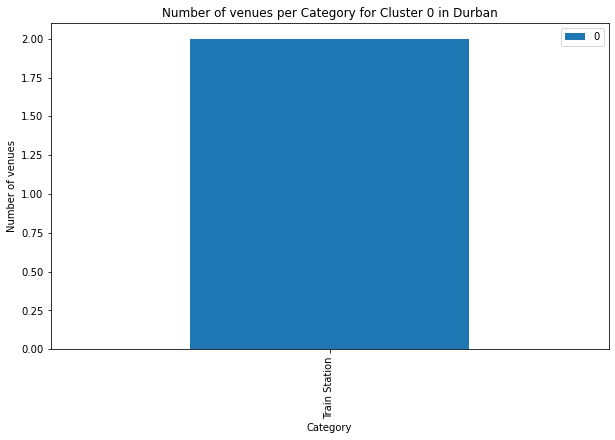

In [100]:
createBarGraph(dbn_sum_transpose, 0, 10, 6, 'Durban')

### Durban Cluster label 1

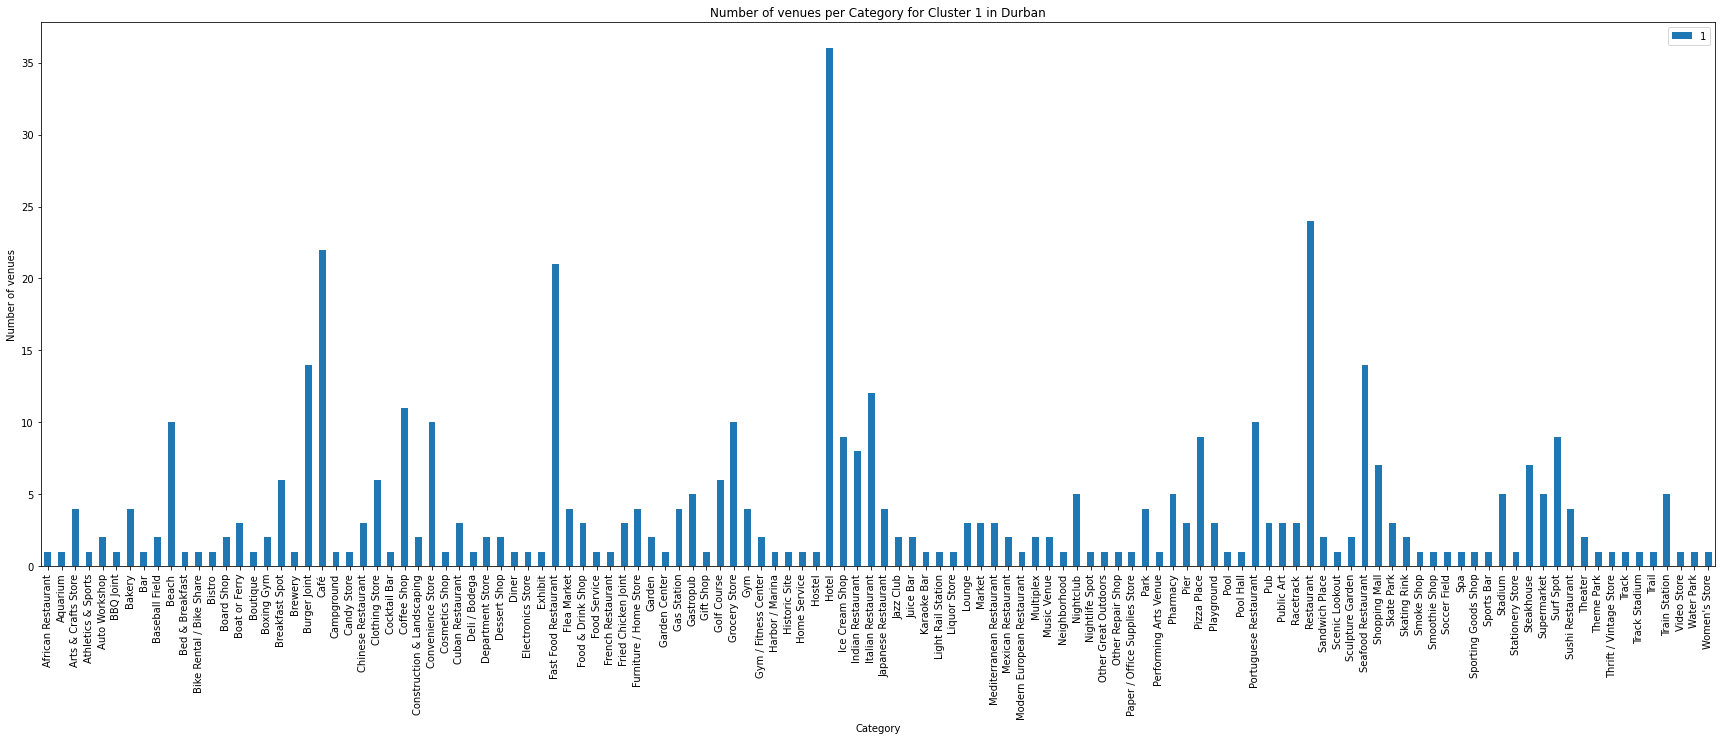

In [101]:
createBarGraph(dbn_sum_transpose, 1, 30, 10, 'Durban')

### Durban Cluster label 2

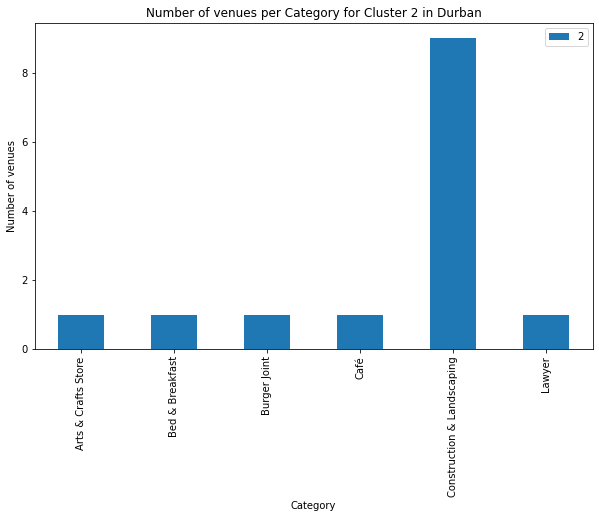

In [102]:
createBarGraph(dbn_sum_transpose, 2, 10, 6, 'Durban')

### Durban Cluster label 3

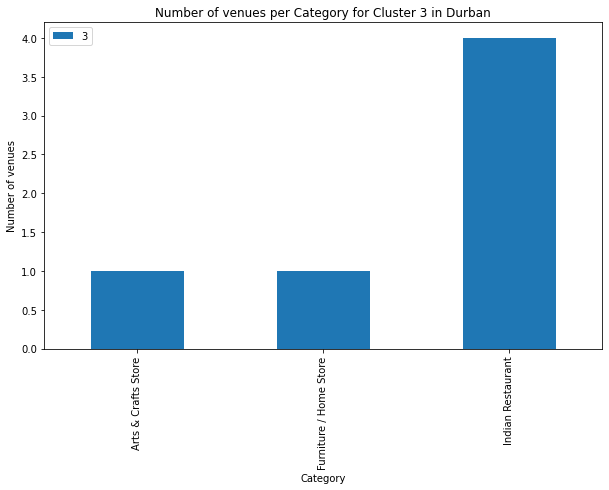

In [103]:
createBarGraph(dbn_sum_transpose, 3, 10, 6, 'Durban')

### Durban Cluster label 4

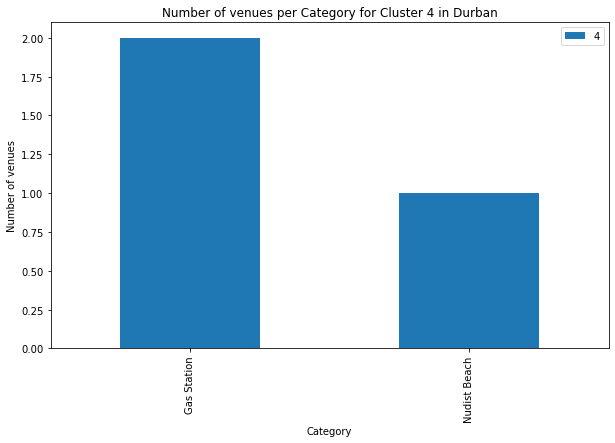

In [104]:
createBarGraph(dbn_sum_transpose, 4, 10, 6, 'Durban')

### Durban Cluster label 5

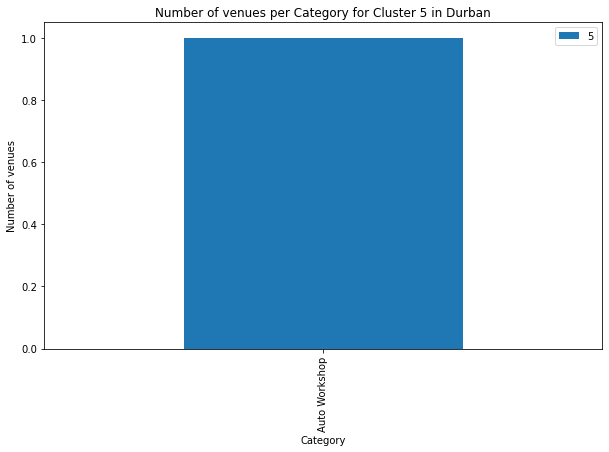

In [105]:
createBarGraph(dbn_sum_transpose, 5, 10, 6, 'Durban')

### Durban Cluster label 6

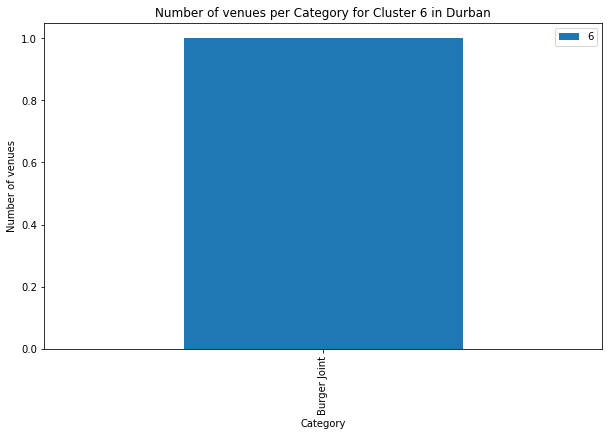

In [106]:
createBarGraph(dbn_sum_transpose, 6, 10, 6, 'Durban')

## Selecting a Business Category from Cape Town

In [107]:
def getPopular(param_df, cluster_name):
    max_sum = param_df[cluster_name].max()
    output_df = param_df[['Category', cluster_name]]
    output_df = output_df[output_df[cluster_name]==max_sum]
    return output_df

In [109]:
cpt_popular = getPopular(cpt_sum_transpose, 0)
cpt_popular

,Category,0
26,Café,71
80,Hotel,71


In Cape Town, from cluster label 0, the most popular venue category is ***hotel*** and ***cafe*** with 71 venues each.

## Cape Town Neighbourhoods in Cluster 0 that contributed to hotel popularity

Finding the neighbourhoods that contributed in making hotels the popular venue category in Cape Town.

In [110]:
def getNeighbourhoodsWithVenue(city_cluster, cluster_num, onehot_df, category):
    neigh_grouped = onehot_df.groupby('Neighbourhood').sum().reset_index() #group by neighbourhood
    cluster_df = city_cluster.copy(deep=True)
    cluster_df['Cluster Labels'] = cluster_df['Cluster Labels'].astype(int) #turn cluster labels column to int
    cluster_df = cluster_df[cluster_df['Cluster Labels']==cluster_num] #keep rows where cluster label is the desired cluster
    neigh_grouped = neigh_grouped[neigh_grouped['Neighbourhood'].isin(cluster_df['Neighbourhood'].to_list())] #keep neighbourhoods that match cluster number neighbourhoods
    output_df = neigh_grouped[['Neighbourhood',category]] #keep desired category
    output_df = output_df[output_df[category]!=0].reset_index() #remove rows where the number of venues in category is zero
    output_df = output_df.drop('index', 1) #remove column index created by reset index call
    return output_df

In [113]:
cpt_contributed_hotel = getNeighbourhoodsWithVenue(cpt_clustered_venues, 0,cpt_onehot,'Hotel')
print('There are {} neighbourhoods that contributed to the popularity of {}\'s in {}.'.format(cpt_contributed_hotel.shape[0], 'Hotel', 'Cape Town'))
cpt_contributed_hotel

There are 27 neighbourhoods that contributed to the popularity of Hotel's in Cape Town.


,Neighbourhood,Hotel
0,Bakoven,1
1,Bantry Bay,3
2,Bishopscourt,1
3,Bloubergstrand,1
4,Bo-Kaap,1
5,Camps Bay,7
6,Clovelly,3
7,Darling,3
8,De Waterkant,12
9,Diep River,2


## Cape Town Neighbourhoods in Cluster 0 that contributed to cafe popularity

In [115]:
cpt_contributed_cafe = getNeighbourhoodsWithVenue(cpt_clustered_venues, 0,cpt_onehot,'Café')
print('There are {} neighbourhoods that contributed to the popularity of {}\'s in {}.'.format(cpt_contributed_cafe.shape[0], 'Café', 'Cape Town'))
cpt_contributed_cafe

There are 24 neighbourhoods that contributed to the popularity of Café's in Cape Town.


,Neighbourhood,Café
0,Bellville,1
1,Bloubergstrand,1
2,Bo-Kaap,5
3,Capri Village,3
4,Claremont,3
5,Clovelly,4
6,Darling,5
7,De Waterkant,10
8,Devil's Peak Estate,2
9,Diep River,1


## Selecting a Business Category from Durban

In [116]:
dbn_popular = getPopular(dbn_sum_transpose, 1)
dbn_popular

,Category,1
57,Hotel,36


In Durban, from cluster label 1, the most popular venue category is ***hotel*** with 36 venues.

## Durban Neighbourhoods in Cluster 1 that contributed to hotel popularity

Finding the neighbourhoods that contributed in making hotels the popular venue category in Durban.

In [117]:
dbn_contributed = getNeighbourhoodsWithVenue(dbn_clustered_venues, 1,dbn_onehot,'Hotel')
print('There are {} neighbourhoods that contributed to the popularity of {}\'s in {}.'.format(dbn_contributed.shape[0], 'Hotel', 'Durban'))
dbn_contributed

There are 14 neighbourhoods that contributed to the popularity of Hotel's in Durban.


,Neighbourhood,Hotel
0,Berea,1
1,Durban North,1
2,Essenwood,1
3,Glenmore,1
4,Kenneth Gardens,1
5,Marine Parade,6
6,Marlborough Park,6
7,Musgrave Road,1
8,North Beach,5
9,Ocean View,1


# Conclusion

Through clustering using the k means algorithm, it was found that the most popular venues in Cape Town were Hotels and Cafes with 71 venues identified in cluster label 0. In Durban it was found that Hotels are also popular with 36 venues in cluster label 1. 27 neighbourhoods contributed to the popularity of hotels in Cape Town while 24 neighbourhoods contributed to the popularity of cafes in Cape Town. In Durban, fourteen neighbourhoods contributed to the popularity of hotels. Even though there is an equal number of hotels and cafes that are popular in Cape Town, hotels are the better choice as they are popular in 27 neighbourhoods while cafes are only popular in 24. Cape Town hotel venue numbers also exceed the number of hotel venues in Durban. 
From these results, it can be concluded that it is better to start a business in Cape Town and in the hotel category.